![alt text][logo]

[logo]: https://github.com/legolason/PyQSOFit/blob/master/QSOFit_logo.png?raw=true


# PyQSOFit


PyQSOFit is a flexible tool to decompose the quasar spectrum. It‘s transferred from [Yue Shen](http://quasar.astro.illinois.edu/)'s IDL qsofit code. With this program, people can get the information of quasar continuum and emission lines, e.g., continuum slope, line FWHM, EW, peak, etc. The main steps of this code are:

1) If needed, we decompose the host galaxy and quasar component with the PCA method

2) Select the line free windows to the continuum with several components (Power-Law, Polynomial, Fe II, Balmer Continuum) 

3) Based on the continuum results, we then fit the line complex one by one. In each complex, broad and narrow Gaussian profiles are used to fit different emission lines. 

For the details, you can read [Shen et al. (2011)](http://adsabs.harvard.edu/abs/2011ApJS..194...45S) and [Guo et al. (2018)]


## Installation and Requirements
To install this code, just copy the whole package to your directory. This code was tested on Python 2.7 and Python 3.6. Some packages are required:

1) [Numpy](http://www.numpy.org/)<br>
2) [Scipy](https://www.scipy.org/)<br>
3) [Astropy](http://www.astropy.org/)<br>
4) [PyAstronomy](https://www.hs.uni-hamburg.de/DE/Ins/Per/Czesla/PyA/PyA/index.html)<br>
5) [Kmpfit](https://www.astro.rug.nl/software/kapteyn/kmpfittutorial.html)<br>
6) [Sfdmap](https://github.com/kbarbary/sfdmap): dust reddening map from [Schlegel et al. (2008)](http://www.adsabs.harvard.edu/abs/1998ApJ...500..525S), which can be downloaded [here](https://github.com/kbarbary/sfddata)<br>
7) Eigenspectra of galaxy and quasar from Yip et al. [(2004a)](http://adsabs.harvard.edu/abs/2004AJ....128..585Y), [(2004b)](http://adsabs.harvard.edu/abs/2004AJ....128.2603Y)<br>
8) Optical/UV Fe II templete (already included in this package).

We suggest that install python through [anaconda](https://www.anaconda.com/), which incorporates most packages you need.  

## Key features
1) Full spectral fit or local fit for AGN continuum and emission lines, it's not suitable to fit galaxies.

2) We note that the error coming from KMPFIT is not trustable, so we did not output the KMPFIT errors as default results. But user still can read out this errors through KMPFIT.param. The better way to calculate the error is using the Monte Carlo method, which perturbs the flux based on the input error. However, this will take a longer time to do the calculation

3) A 3rd order polynomial component can be added to explain the possible dust reddening for continuum fitting.

4) Iterative sigma clipping can be used to clean the spectrum for continuum fitting. 

5) One can block serval ranges on the spectrum for bad S/N ratio pixels or absorption lines.

6) The code directly saves out the properties of emission lines, e.g., FWHM, EW, Peak, line flux for the broad components and continuum luminosity at 1350, 3000, 5100A.

7) One can remove bad pixels caused by the cosmic ray or the sky. 



## Possible future updates
1) Add Gauss-Hermite profile to fit the emission lines.<br>
2) Simultaneously fit several epochs for the same source since the time domain era.<br>
3) Add functions to fit the absorption lines.<br>
4) Produce more secondary parameters from spectral fitting.<br>


## Disadvantages
1) Speed problem. Comparing to the IDL version, the speed bottleneck is the core function Kmpfit based on Cython. For each source, it takes about 3 ~ 20s. If add the MC method to calculate the error, it will take about 5 to 10 Min for each source. Excluding the polynomial component or choosing proper initial parameters will alleviate this problem. 

2) Now for the parameter "fvalue" to tie the flux of two lines, the limitation is that we can only tie TWO pairs of lines (four lines) to certain values, but not a range. 

3) For very low S/N ratio spectral and BAL quasar, the performance is not good. Try to exclude them before fitting if a larger sample is used.

## Detailed Usage

__Step 1__:<br>
Firstly, run the script below to produce the qsopar.fits listing the lines and their constraints, which will be needed in the following fitting program. From this file, you can change some specific parameters to suit your requirements, e.g., fitting range, line width, tie line center, tie line sigma, etc. If you want to fit extra lines, you can add it into the list. Note that our line wavelength and sigma in the list are in Ln scale, like Lnlambda, Lnsigma. 

In [4]:
%matplotlib inline
import glob, os,sys,timeit
import matplotlib
import numpy as np
from PyQSOFit import QSOFit
from astropy.io import fits
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

path='/Users/legolason/study/mesfit/'

newdata = np.rec.array([(6564.61,'Ha',6400.,6800.,'Ha_br',3,5e-3,0.004,0.05,0.015,0,0,0,0.05),\
                        (6564.61,'Ha',6400.,6800.,'Ha_na',1,1e-3,5e-4,0.002,0.01,1,1,0,0.002),\
                        (6549.85,'Ha',6400.,6800.,'NII6549',1,1e-3,2.3e-4,0.002,5e-3,1,1,1,0.001),\
                        (6585.28,'Ha',6400.,6800.,'NII6585',1,1e-3,2.3e-4,0.002,5e-3,1,1,1,0.003),\
                        (6718.29,'Ha',6400.,6800.,'SII6718',1,1e-3,2.3e-4,0.002,5e-3,1,1,2,0.001),\
                        (6732.67,'Ha',6400.,6800.,'SII6732',1,1e-3,2.3e-4,0.002,5e-3,1,1,2,0.001),\
                        (4862.68,'Hb',4640.,5100.,'Hb_br',3,5e-3,0.004,0.05,0.01,0,0,0,0.01),\
                        (4862.68,'Hb',4640.,5100.,'Hb_na',1,1e-3,2.3e-4,0.002,0.01,1,1,0,0.002),\
                        (4960.30,'Hb',4640.,5100.,'OIII4959c',1,1e-3,2.3e-4,0.002,0.01,1,1,0,0.002),\
                        (5008.24,'Hb',4640.,5100.,'OIII5007c',1,1e-3,2.3e-4,0.002,0.01,1,1,0,0.004),\
                        (4960.30,'Hb',4640.,5100.,'OIII4959w',1,3e-3,2.3e-4,0.004,0.01,0,0,0,0.001),\
                        (5008.24,'Hb',4640.,5100.,'OIII5007w',1,3e-3,2.3e-4,0.004,0.01,0,0,0,0.002),\
                        (4687.02,'Hb',4640.,5100.,'HeII4687_br',1,5e-3,0.004,0.05,0.005,0,0,0,0.001),\
                        (4687.02,'Hb',4640.,5100.,'HeII4687_na',1,1e-3,2.3e-4,0.002,0.005,1,1,0,0.001),\
                        #(3934.78,'CaII',3900.,3960.,'CaII3934',2,1e-3,3.333e-4,0.002,0.01,99,0,0,-0.001),\
                        #(3728.48,'OII',3650.,3800.,'OII3728',1,1e-3,3.333e-4,0.002,0.01,1,1,0,0.001),\
                        #(3426.84,'NeV',3380.,3480.,'NeV3426',1,1e-3,3.333e-4,0.002,0.01,0,0,0,0.001),\
                        #(3426.84,'NeV',3380.,3480.,'NeV3426_br',1,5e-3,0.0025,0.02,0.01,0,0,0,0.001),\
                        (2798.75,'MgII',2700.,2900.,'MgII_br',1,5e-3,0.004,0.05,0.015,0,0,0,0.05),\
                        #(2798.75,'MgII',2700.,2900.,'MgII_na',1,1e-3,5e-4,0.002,0.01,1,1,0,0.002),\
                        (1908.73,'CIII',1700.,1970.,'CIII_br',2,5e-3,0.004,0.05,0.015,99,0,0,0.01),\
                        #(1908.73,'CIII',1700.,1970.,'CIII_na',1,1e-3,5e-4,0.002,0.01,1,1,0,0.002),\
                        #(1892.03,'CIII',1700.,1970.,'SiIII1892',1,2e-3,0.001,0.015,0.003,1,1,0,0.005),\
                        #(1857.40,'CIII',1700.,1970.,'AlIII1857',1,2e-3,0.001,0.015,0.003,1,1,0,0.005),\
                        #(1816.98,'CIII',1700.,1970.,'SiII1816',1,2e-3,0.001,0.015,0.01,1,1,0,0.0002),\
                        #(1786.7,'CIII',1700.,1970.,'FeII1787',1,2e-3,0.001,0.015,0.01,1,1,0,0.0002),\
                        #(1750.26,'CIII',1700.,1970.,'NIII1750',1,2e-3,0.001,0.015,0.01,1,1,0,0.001),\
                        #(1718.55,'CIII',1700.,1900.,'NIV1718',1,2e-3,0.001,0.015,0.01,1,1,0,0.001),\
                        (1549.06,'CIV',1500.,1700.,'CIV_br',1,5e-3,0.004,0.05,0.015,0,0,0,0.05),\
                        #(1549.06,'CIV',1500.,1700.,'CIV_na',1,1e-3,5e-4,0.002,0.01,1,1,0,0.002),\
                        #(1640.42,'CIV',1500.,1700.,'HeII1640',1,1e-3,5e-4,0.002,0.008,1,1,0,0.002),\
                        #(1663.48,'CIV',1500.,1700.,'OIII1663',1,1e-3,5e-4,0.002,0.008,1,1,0,0.002),\
                        #(1640.42,'CIV',1500.,1700.,'HeII1640_br',1,5e-3,0.0025,0.02,0.008,1,1,0,0.002),\
                        #(1663.48,'CIV',1500.,1700.,'OIII1663_br',1,5e-3,0.0025,0.02,0.008,1,1,0,0.002),\
                        #(1402.06,'SiIV',1290.,1450.,'SiIV_OIV1',1,5e-3,0.002,0.05,0.015,1,1,0,0.05),\
                        #(1396.76,'SiIV',1290.,1450.,'SiIV_OIV2',1,5e-3,0.002,0.05,0.015,1,1,0,0.05),\
                        #(1335.30,'SiIV',1290.,1450.,'CII1335',1,2e-3,0.001,0.015,0.01,1,1,0,0.001),\
                        #(1304.35,'SiIV',1290.,1450.,'OI1304',1,2e-3,0.001,0.015,0.01,1,1,0,0.001),\
                        (1215.67,'Lya',1150.,1290.,'Lya_br',1,5e-3,0.004,0.05,0.02,0,0,0,0.05),\
                        (1215.67,'Lya',1150.,1290.,'Lya_na',1,1e-3,5e-4,0.002,0.01,0,0,0,0.002)\
                        ],\
                     formats='float32,a20,float32,float32,a20,float32,float32,float32,float32,\
                     float32,float32,float32,float32,float32',\
                     names='lambda,compname,minwav,maxwav,linename,ngauss,inisig,minsig,maxsig,voff,vindex,windex,findex,fvalue')
#------header-----------------
hdr = fits.Header()
hdr['lambda'] = 'Vacuum Wavelength in Ang'
hdr['minwav'] = 'Lower complex fitting wavelength range'
hdr['maxwav'] = 'Upper complex fitting wavelength range'
hdr['ngauss'] = 'Number of Gaussians for the line'
hdr['inisig'] = 'Initial guess of linesigma [in lnlambda]'
hdr['minsig'] = 'Lower range of line sigma [lnlambda]'
hdr['maxsig'] = 'Upper range of line sigma [lnlambda]'
hdr['voff  '] = 'Limits on velocity offset from the central wavelength [lnlambda]'
hdr['vindex'] = 'Entries w/ same NONZERO vindex constrained to have same velocity'
hdr['windex'] = 'Entries w/ same NONZERO windex constrained to have same width'
hdr['findex'] = 'Entries w/ same NONZERO findex have constrained flux ratios'
hdr['fvalue'] = 'Relative scale factor for entries w/ same findex'
#------save line info-----------
hdu = fits.BinTableHDU(data=newdata,header=hdr,name='data')
hdu.writeto(path+'qsopar.fits',overwrite=True)


__Step 2__:<br>
Setup the paths and read in the raw data. Our code is written under the frame of SDSS spectral data format. Other data is also available if they including wavelength, flux, error, and redshift, and make sure the wavelength resolution is the same as SDSS spectrum (For SDSS the pixel scale is 1.e-4 in log space).

In [5]:

path1='/Users/legolason/study/mesfit/'                  # the path of the source code file and qsopar.fits
path2='/Users/legolason/study/mesfit/test/data/result/' # path of fitting results
path3='/Users/legolason/study/mesfit/test/data/QA_l/'   # path of figure 
path4='/Users/legolason/study/sed/dustmap/'             # path of dusp reddening map

#Requried
# an important note that all the data input must be finite, especically for the error !!!
data=fits.open(path1+'test/data/low/spec-0332-52367-0639.fits') 
lam=10**data[1].data['loglam']        # OBS wavelength [A]
flux=data[1].data['flux']             # OBS flux [erg/s/cm^2/A]
err=1./np.sqrt(data[1].data['ivar'])  # 1 sigma error
z=data[2].data['z'][0]                # Redshift

#Optinal
ra=data[0].header['plug_ra']          # RA 
dec=data[0].header['plug_dec']        # DEC
plateid = data[0].header['plateid']   # SDSS plate ID
mjd = data[0].header['mjd']           # SDSS MJD
fiberid = data[0].header['fiberid']   # SDSS fiber ID



__Step 3__:<br>
Input the data, choose the setup, and run spectral fitting. We note that the default settings do not equal to the correct settings! It depends on what science you need. 

Fitting finished in : 13.0s


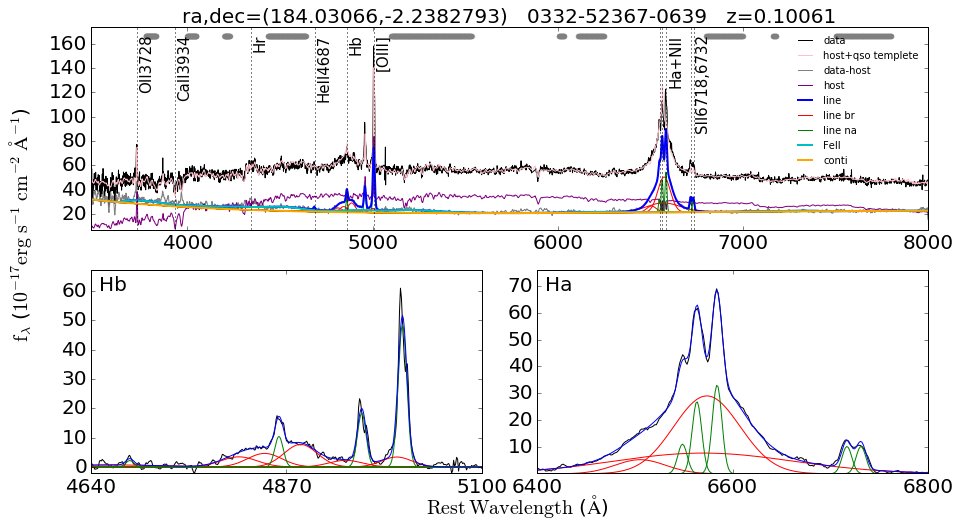

In [8]:
# get data prepared 
q = QSOFit(lam, flux, err, z, ra = ra, dec = dec, plateid = plateid, mjd = mjd, fiberid = fiberid, path = path1)

start = timeit.default_timer()
# do the fitting
q.Fit(name = None,nsmooth = 1, and_or_mask = False, deredden = True, reject_badpix = False, wave_range = None, wave_mask =None,\
   decomposition_host = True, Mi = None, npca_gal = 5, npca_qso = 20, nsmooth_qso = 5,\
   Fe_uv_op = True, poly = True, BC = False, rej_abs = False, initial_guess = None, MC = False, \
    n_trails = 5, linefit = True, tie_lambda = True, tie_width = True, tie_flux_1 = True, tie_flux_2 = True,
   save_result = True, plot_fig = True,save_fig = True, plot_line_name = True, plot_legend = True, \
      dustmap_path = path4, save_fig_path = path3, save_fits_path = path2,save_fits_name = 'result')

end = timeit.default_timer()
print 'Fitting finished in : '+str(np.round(end-start))+'s'
# grey shade on the top is the continuum windiows used to fit.

### Get data and models for the whole spectrum
For some users, they may want to do some further calculations based on our fitting results. Here, we show how to extract the different data and models from our results.

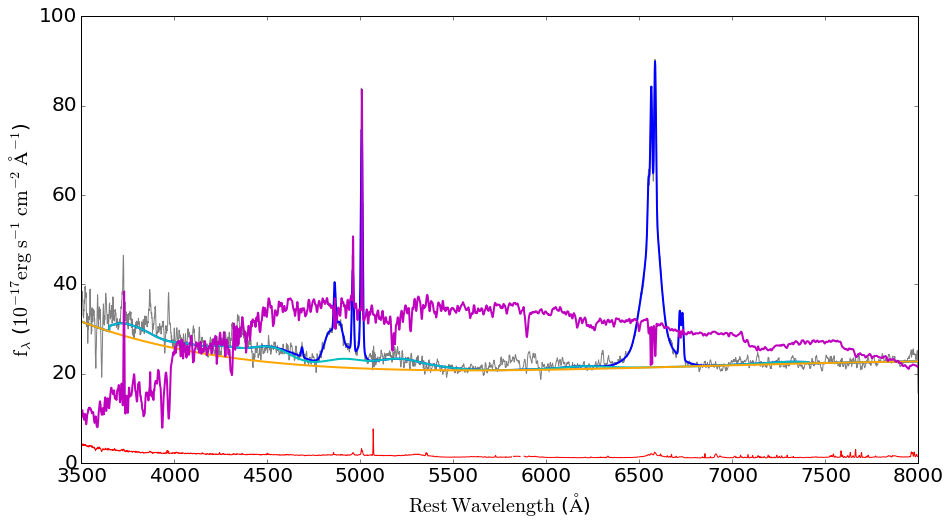

In [9]:
fig=plt.figure(figsize=(15,8))
#plot the quasar rest frame spectrum after removed the host galaxy component
plt.plot(q.wave,q.flux,'grey')              
plt.plot(q.wave,q.err,'r')


#To plot the whole model, we use Manygauss to reappear the line fitting results saved in gauss_result  
plt.plot(q.wave,q.Manygauss(np.log(q.wave),q.gauss_result)+q.f_conti_model,'b',label='line',lw=2)
plt.plot(q.wave,q.f_conti_model,'c',lw=2)
plt.plot(q.wave,q.PL_poly_BC,'orange',lw=2)
plt.plot(q.wave,q.host,'m',lw=2)

plt.xlim(3500,8000)
plt.xlabel(r'$\rm Rest \, Wavelength$ ($\rm \AA$)',fontsize = 20)
plt.ylabel(r'$\rm f_{\lambda}$ ($\rm 10^{-17} erg\;s^{-1}\;cm^{-2}\;\AA^{-1}$)',fontsize = 20)

### Get the data and model for each complex
All the line parameters are in the gauss_result, it was saved following the order of qsopar.fits. For each Gaussian, three parameter (scalar, Lnlambda, Lnsigma) are saved.
If you want to filter the line below or above 1200 km/s (lnsigma = 0.0017), the function CalFWHM can be used as following.
The line_prop is desiged to calculate the broad line properties, not for the narrow line.

Hb complex:
('FWHM (km/s)', 6237.1219949718225)
('Sigma (km/s)', 2218.3117383661292)
('EW (A)', 37.122236162050861)
('Peak (A)', 4883.2718435822062)
('area (10^(-17) erg/s/cm^2)', 795.84200563038655)


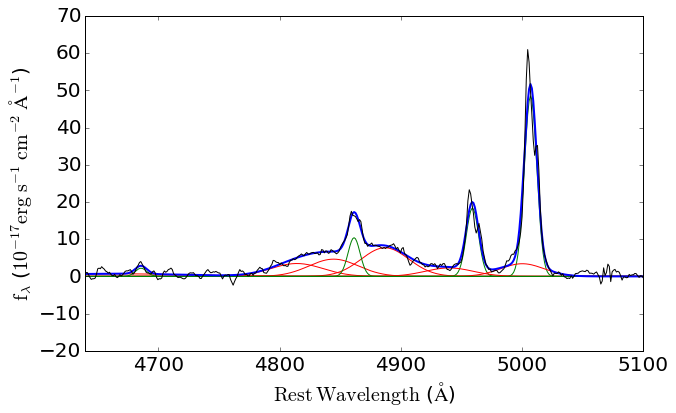

In [10]:
fig=plt.figure(figsize=(10,6))
for p in range(int(len(q.gauss_result)/3)):
    if q.CalFWHM(q.gauss_result[3*p+1],q.gauss_result[3*p+2] ) < 1200.:  # < 1200 km/s narrow
        color = 'g'
    else:
        color = 'r'
    plt.plot(q.wave,q.Onegauss(np.log(q.wave),q.gauss_result[p*3:(p+1)*3]),color=color)
plt.plot(q.wave,q.Manygauss(np.log(q.wave),q.gauss_result),'b',lw=2)
plt.plot(q.wave,q.line_flux,'k')
plt.xlim(4640,5100)
plt.xlabel(r'$\rm Rest \, Wavelength$ ($\rm \AA$)',fontsize = 20)
plt.ylabel(r'$\rm f_{\lambda}$ ($\rm 10^{-17} erg\;s^{-1}\;cm^{-2}\;\AA^{-1}$)',fontsize = 20)


# the line_prop function is used to calculate the broad line properties (Lnsigma > 0.0017 (1200 km/s) )
fwhm,sigma,ew,peak,area = q.line_prop(q.linelist[6][0],q.gauss_result[0:27]) 
print("Hb complex:")
print("FWHM (km/s)", fwhm)
print("Sigma (km/s)", sigma)
print("EW (A)",ew)
print("Peak (A)",peak)
print("area (10^(-17) erg/s/cm^2)",area)


### Multiprocessing
Since our code is not faster as IDL version and to calculate the MC-based uncertainties will cost a lot of time, we always use the multiprocessing method to speed up the large sample fitting. 

In [ ]:
# Edit the directory before use. 

from multiprocessing import Pool

def job(files):
    data=fits.open(files)
    
    lam = 10**data[1].data['loglam']
    flux =data[1].data['flux']
    err = 1./np.sqrt(data[1].data['ivar'])
    ra = data[0].header['plug_ra']
    dec = data[0].header['plug_dec']
    z = data[2].data['z'][0]
    plateid = data[0].header['plateid']
    mjd = data[0].header['mjd']
    fiberid = data[0].header['fiberid']
    
    q = QSOFit(lam, flux, err, z, ra = ra, dec = dec, plateid = plateid, mjd = mjd, fiberid = fiberid, path = path1)

    q.Fit(name = None,nsmooth = 1, and_or_mask = False, deredden = True, reject_badpix = False, wave_range = None, wave_mask =None,\
       decomposition_host = True, Mi = None, npca_gal = 5, npca_qso = 20, nsmooth_qso = 1,\
       Fe_uv_op = True, poly = True, BC = False, rej_abs = False, initial_guess = None, MC = False, \
        n_trails = 5, linefit = True, tie_lambda = True, tie_width = True, tie_flux_1 = False, tie_flux_2 = False,
       save_result = False, plot_fig = True,save_fig = True, plot_line_name = True, plot_legend = True, \
          dustmap_path = path4, save_fig_path = path3, save_fits_path = path2,save_fits_name = None)
    
if __name__ == '__main__':
    start = timeit.default_timer()
    
    files = []
    for path in zip(glob.glob(path1+'test/data/low/*.fits')):
        files.append(path[0])
    
    pool = Pool()                         # Create a multiprocessing Pool
    pool.map(job, files)
    
    end = timeit.default_timer()
    print('Fitting finished in : '+str(np.round(end-start))+'s')